100%|██████████| 10/10 [00:00<00:00, 223.13it/s]


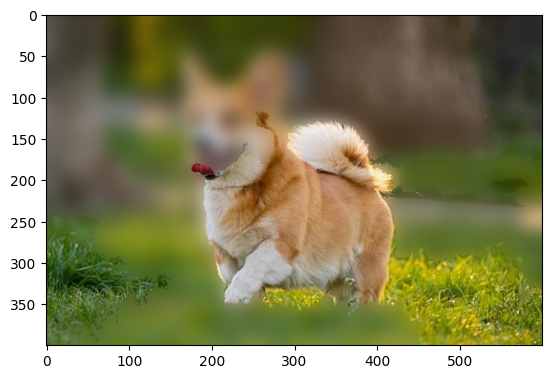

In [1]:
from functools import partial
from samplers import MeanSampler, exponential_kernel, BlurSampler, BlackOutSampler
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import skimage.segmentation as seg

image = Image.open("./data/dog.jpg")
image = np.array(image)

segments = seg.slic(image, n_segments=25, compactness=10)

image = image.transpose(2, 0, 1)

fudged_image = np.zeros_like(image)

sampler = BlurSampler(image, segments, exponential_kernel)



s = sampler.sample(10)

plt.imshow(s[0][1].transpose(1, 2, 0))

In [2]:
from samplers import FlowSampler
from models import GLOW

import torch

from torchvision.datasets import CelebA
from torchvision import transforms

from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(96),
    transforms.CenterCrop(96),
])

flow = GLOW(3, 32, (3, 96, 96), 40, 256)
flow.model.load_state_dict(torch.load('models/glow/glow_celeba_3_32_256_50000.pt'))

/home/mando/glime/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
/home/mando/glime/.venv/lib/python3.10/site-packages/torch/_tensor.py:791: UserWarning: torch.lu is deprecated in favor of torch.linalg.lu_factor / torch.linalg.lu_factor_ex and will be removed in a future PyTorch release.
LU, pivots = torch.lu(A, compute_pivots)
should be replaced with
LU, pivots = torch.linalg.lu_factor(A, compute_pivots)
and
LU, pivots, info = torch.lu(A, compute_pivots, get_infos=True)
should be replaced with
LU, pivots, info = torch.linalg.lu_factor_ex(A, compute_pivots) (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1984.)
  LU, pivots, in

<All keys matched successfully>

In [3]:
image = Image.open("./data/243.jpg")
image = np.array(image)

segments = seg.slic(image, n_segments=25, compactness=10)

standard_basis = np.eye(40)

image = image.transpose(2, 0, 1)
sampler = FlowSampler(image, segments, exponential_kernel, flow, transform, standard_basis)
sampler.sample(10)

/home/mando/glime/glime-neo/models.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).to(self.device)
100%|██████████| 10/10 [00:01<00:00,  8.36it/s]


In [4]:
np.eye(40).shape

(40, 40)